In [48]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv', sep=',', na_values=' ?').dropna()



In [49]:
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [50]:
df['NObeyesdad'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [51]:
le = LabelEncoder()
for col in df[["NObeyesdad", "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "CALC", "MTRANS", "SCC"]]:
    df[col] = le.fit_transform(df[col])

X = df.drop("NObeyesdad", axis=1)
y = df['NObeyesdad']

## PCA 分群狀況視覺化

In [52]:
def PCA_illustrator(X ,label):
    from sklearn.decomposition import PCA
    pca = PCA(2)
    data = pca.fit_transform(X)
    uniq = np.unique(label)
    plt.figure(figsize=(10,10))
    for i in uniq:
        plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
    #This is done to find the centroid for each clusters.
    plt.legend()
    plt.show()

## DBSCAN 最佳距離判斷圖

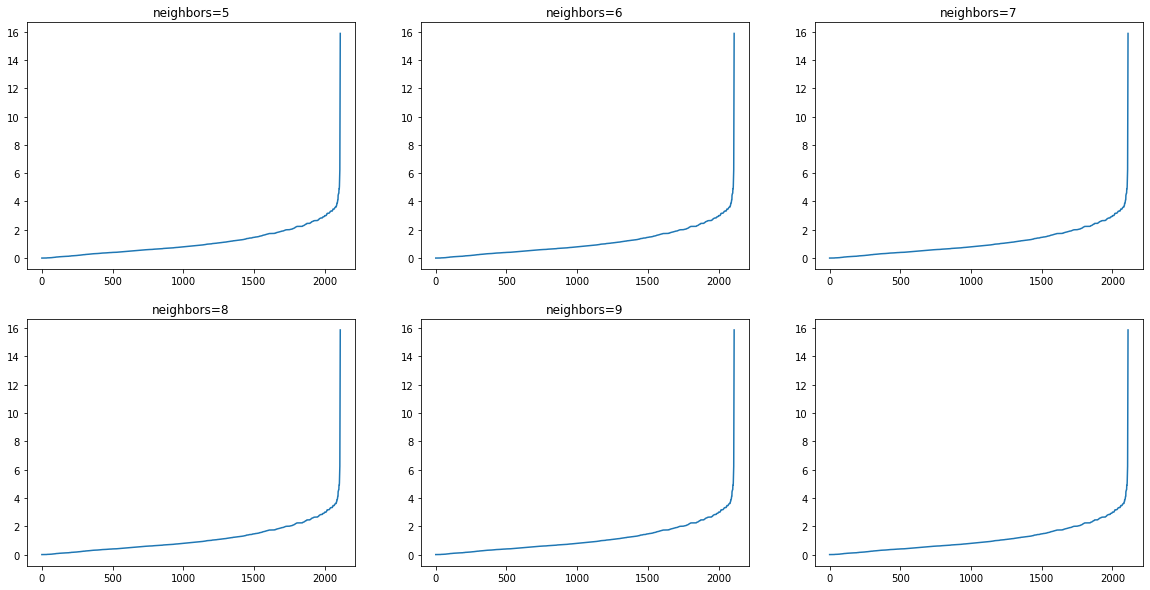

In [53]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

def Best_eps(X, min=4, max=10):
    if not(max - min == 6):
        print('範圍必須等於6')
    else:
        plt.figure(figsize=(20,10))
        for i in range(4, 10):
            neighbors = NearestNeighbors(n_neighbors=i)
            neighbors_fit = neighbors.fit(X)
            distances, indices = neighbors_fit.kneighbors(X)

            distances = np.sort(distances, axis=0)
            distances = distances[:,1]
            plt.title(f'neighbors={i}')
            plt.subplot(2, 3, i - 3)
            plt.plot(distances)
        plt.show()

Best_eps(X)

## 運行時間


In [54]:
if __name__ == '__main__':
    def k_mean():
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=7)
        kmeans.fit(X)
        pred_y = kmeans.predict(X)
        centroids = kmeans.cluster_centers_
        return pred_y

    def AgglomerativeClustering():
        from sklearn.cluster import AgglomerativeClustering
        ml = AgglomerativeClustering(
            n_clusters=7, affinity='euclidean', linkage='ward')
        pred_y = ml.fit_predict(X)
        return pred_y

    def DBSCAN(eps = 4, min_samples = 8):
        from sklearn.cluster import DBSCAN
        clustering = DBSCAN(eps = eps, min_samples = min_samples).fit(X)
        pred_y = clustering.labels_
        return pred_y


In [55]:
from timeit import timeit

X = df.drop("NObeyesdad", axis=1)
y = df['NObeyesdad']
le = LabelEncoder()
df["NObeyesdad"] = le.fit_transform(df["NObeyesdad"])

clusterList = ['k_mean', 'AgglomerativeClustering', 'DBSCAN']
for cluster in clusterList:
    t = timeit(f'{cluster}()', f'from __main__ import {cluster}', number=1)
    print(cluster, t)


k_mean 0.20009350000000836
AgglomerativeClustering 0.1852558000000215
DBSCAN 0.06340660000000753


## 純度


In [56]:
#直接算純度
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


kmean_purity = purity_score(y, k_mean())
AgglomerativeClustering_purity = purity_score(y, AgglomerativeClustering())
DBSCAN_purity = purity_score(y, DBSCAN())
print("kmean_purity", kmean_purity, "\nAgglomerativeClustering_purity",
      AgglomerativeClustering_purity, "\nDBSCAN_purity", DBSCAN_purity)


kmean_purity 0.5243960208432022 
AgglomerativeClustering_purity 0.5329227854097585 
DBSCAN_purity 0.1942207484604453


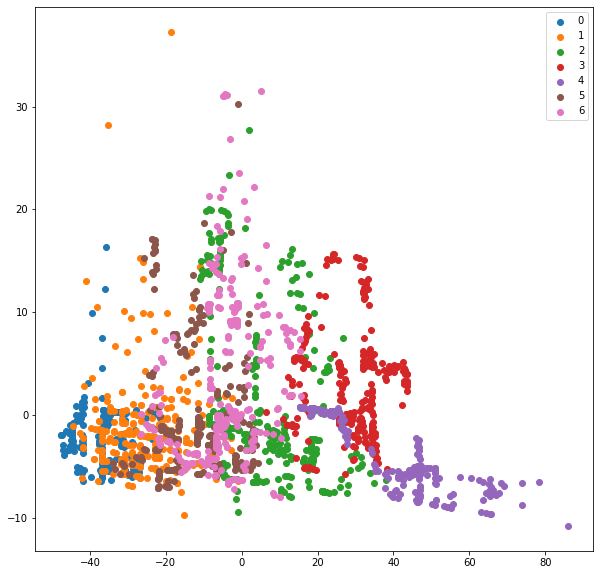

In [57]:
PCA_illustrator(X ,y)

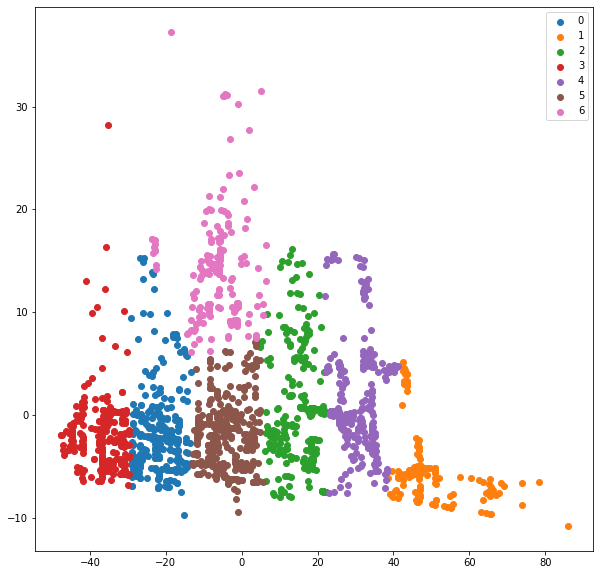

In [58]:
PCA_illustrator(X ,k_mean())

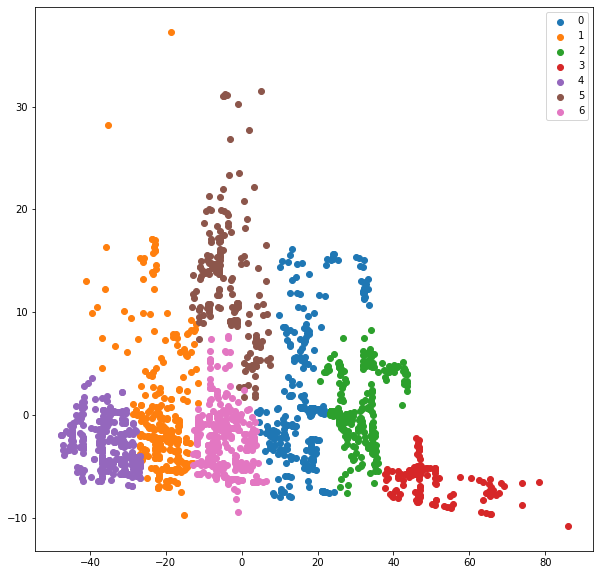

In [59]:
PCA_illustrator(X ,AgglomerativeClustering())

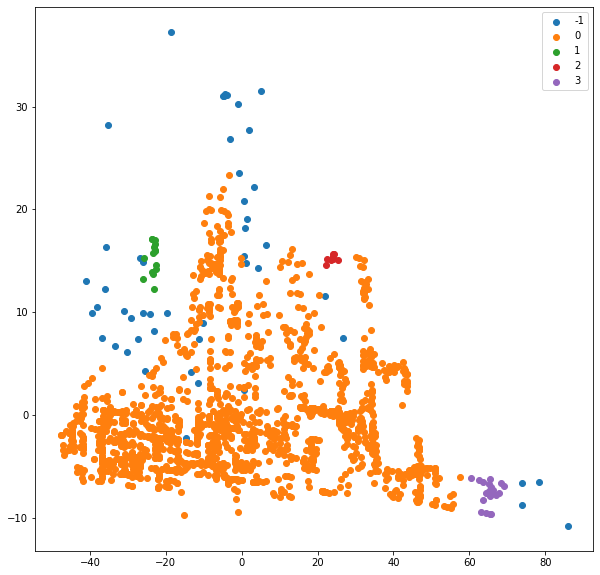

In [60]:
PCA_illustrator(X ,DBSCAN())

In [61]:
#做 MAX-min標準化後純度
from sklearn.preprocessing import MinMaxScaler


le = LabelEncoder()
df["NObeyesdad"] = le.fit_transform(df["NObeyesdad"])

X = df.drop("NObeyesdad", axis=1)
y = df['NObeyesdad']

min_max = MinMaxScaler()
X = pd.DataFrame(min_max.fit_transform(X), columns=X.columns)

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


kmean_purity = purity_score(y, k_mean())
AgglomerativeClustering_purity = purity_score(y, AgglomerativeClustering())
DBSCAN_purity = purity_score(y, DBSCAN())
print("kmean_purity", kmean_purity, "\nAgglomerativeClustering_purity",
      AgglomerativeClustering_purity, "\nDBSCAN_purity", DBSCAN_purity)


kmean_purity 0.41260066319279964 
AgglomerativeClustering_purity 0.4097584083372809 
DBSCAN_purity 0.1662719090478446


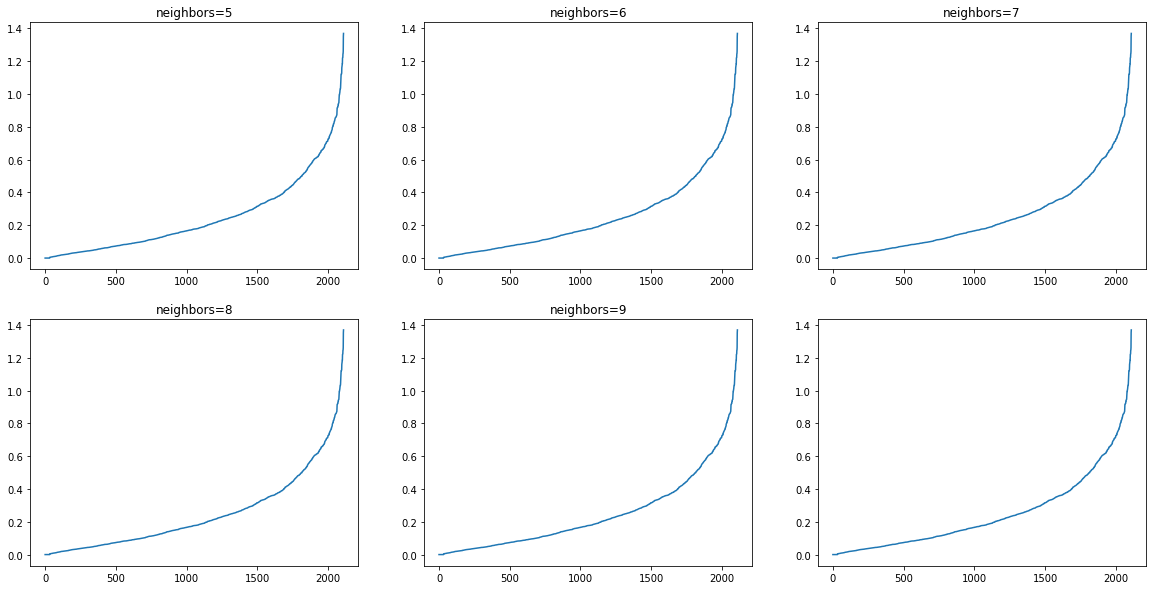

In [62]:
Best_eps(X)

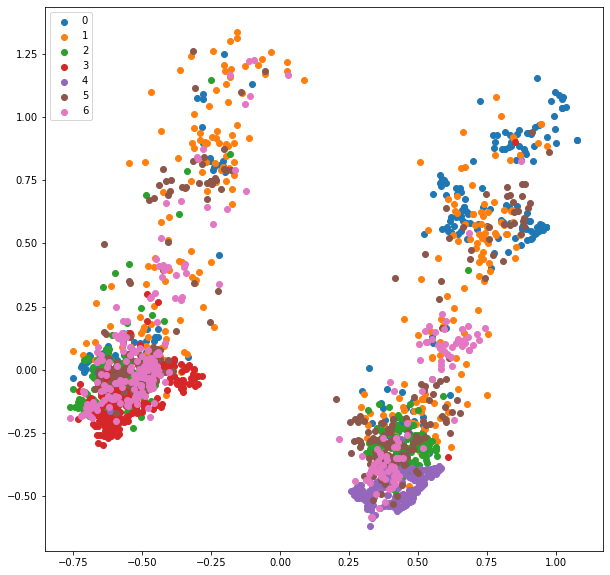

In [63]:
PCA_illustrator(X ,y)

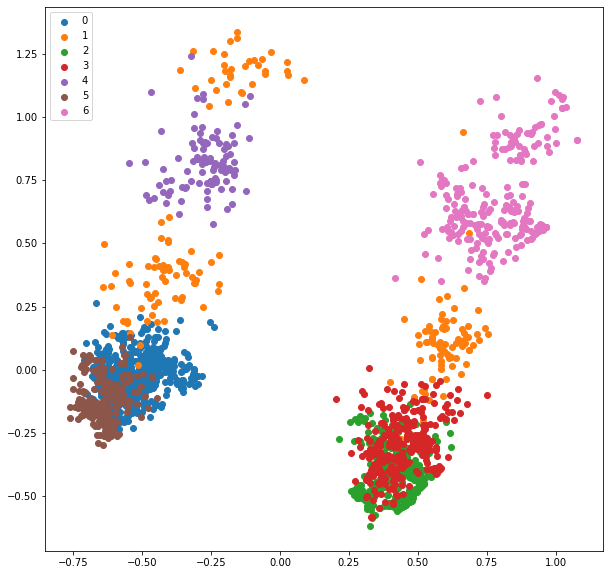

In [64]:
PCA_illustrator(X ,k_mean())

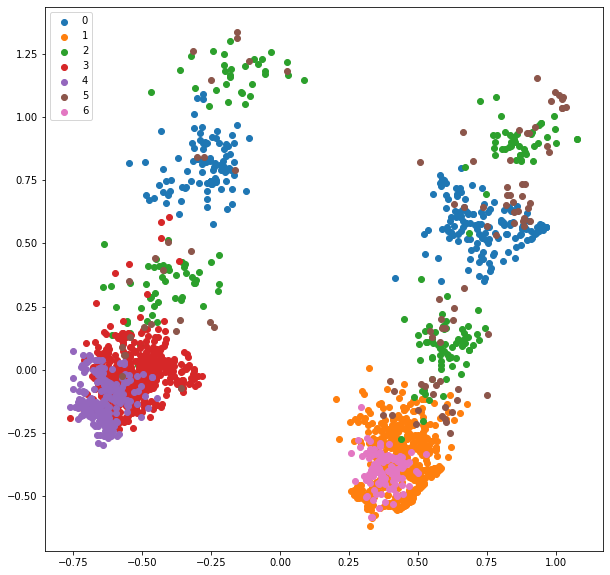

In [65]:
PCA_illustrator(X ,AgglomerativeClustering())

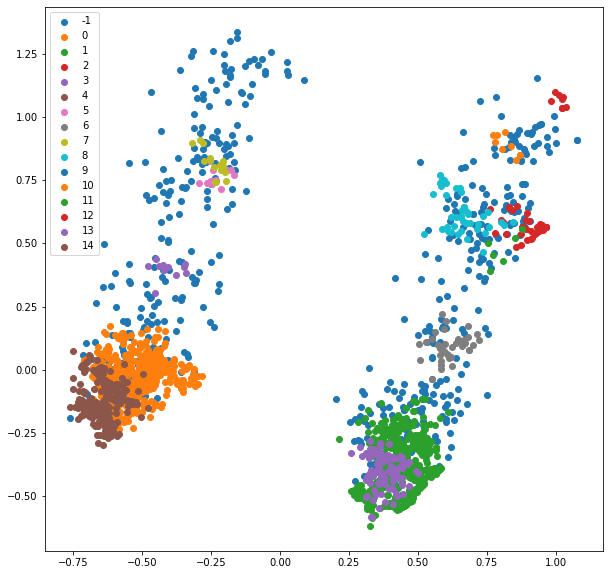

In [66]:
PCA_illustrator(X ,DBSCAN(eps=0.5, min_samples=8))

In [67]:
# z-score 標準化後純度
from sklearn.preprocessing import StandardScaler


le = LabelEncoder()
df["NObeyesdad"] = le.fit_transform(df["NObeyesdad"])
X = df.drop("NObeyesdad", axis=1)
y = df['NObeyesdad']

sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


kmean_purity = purity_score(y, k_mean())
AgglomerativeClustering_purity = purity_score(y, AgglomerativeClustering())
DBSCAN_purity = purity_score(y, DBSCAN())
print("kmean_purity", kmean_purity, "\nAgglomerativeClustering_purity",
      AgglomerativeClustering_purity, "\nDBSCAN_purity", DBSCAN_purity)


kmean_purity 0.4173377546186641 
AgglomerativeClustering_purity 0.4107058266224538 
DBSCAN_purity 0.19564187588820464


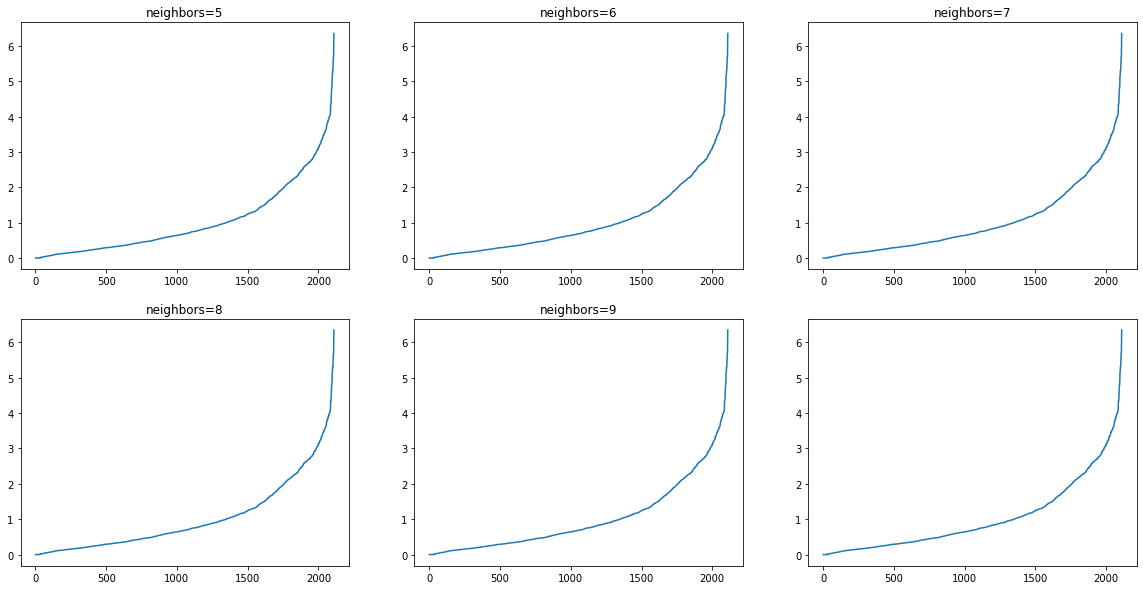

In [68]:
Best_eps(X)

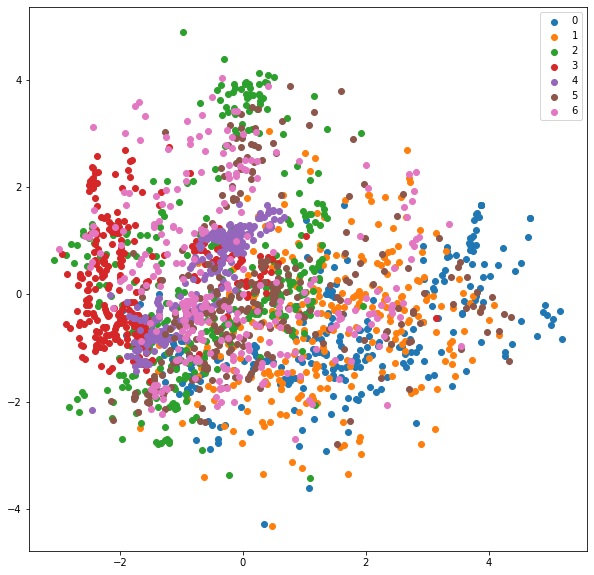

In [69]:
PCA_illustrator(X ,y)

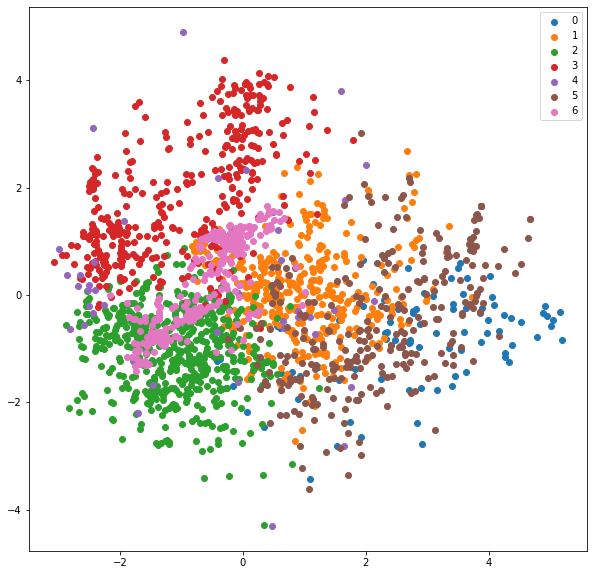

In [70]:
PCA_illustrator(X ,k_mean())

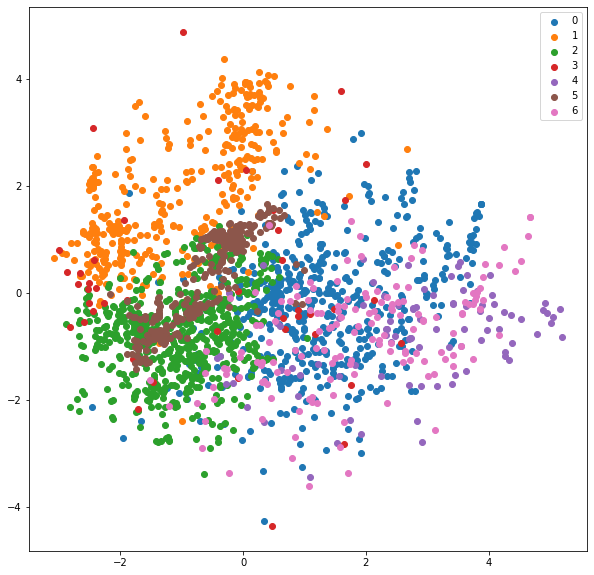

In [71]:
PCA_illustrator(X ,AgglomerativeClustering())

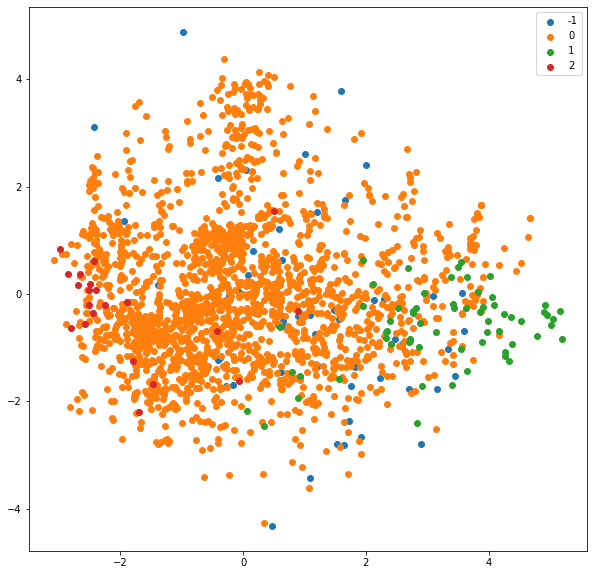

In [72]:
PCA_illustrator(X ,DBSCAN())

## 建構 dendrogram


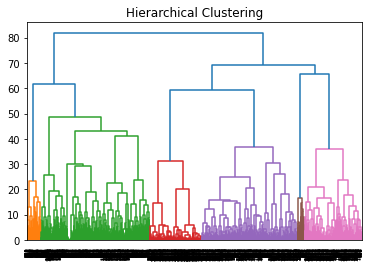

In [73]:
import scipy.cluster.hierarchy as sch


dis = sch.linkage(X, metric='euclidean', method='ward')
sch.dendrogram(dis)
plt.title('Hierarchical Clustering')
plt.show()


## 選擇 eps,min_samples

NameError: name 'pred_y' is not defined

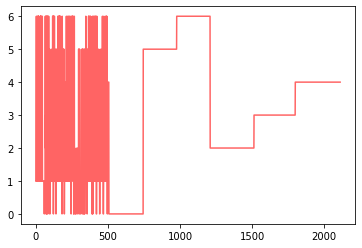

In [74]:

plt.plot(y,color=(255/255,100/255,100/255))
plt.plot(pred_y, color=(100/255,100/255,255/255))

plt.ylabel("Accuracy")
plt.xlabel("Depth_of_tree")
plt.title("Adult_dataset_accuracy")
plt.xlim([0,21])
plt.grid(True)

plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=1, min_samples=1).fit(X)
pred_y = clustering.labels_
allcol=['sepal_length', 'sepal_width',
              'petal_length', 'petal_width']
X_axis="sepal_length"

In [ ]:
test_list = k_mean()

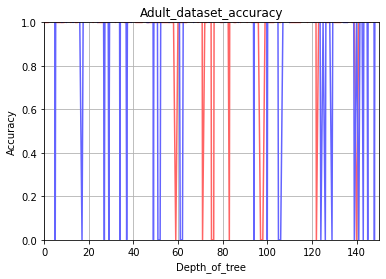

In [ ]:

plt.plot(y,color=(255/255,100/255,100/255))
plt.plot(test_list,color=(100/255,100/255,255/255))

plt.ylabel("Accuracy")
plt.xlabel("Depth_of_tree")
plt.title("Adult_dataset_accuracy")
plt.xlim([0,150])
plt.ylim([0,1])
plt.grid(True)

plt.show()

In [ ]:

plt.scatter(X[X_axis],y,c='r')
plt.scatter(X[X_axis],pred_y,c='b')
plt.xlabel(X_axis)
plt.ylabel('y')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

X_pca.shape

(2111, 2)

<Figure size 432x288 with 0 Axes>

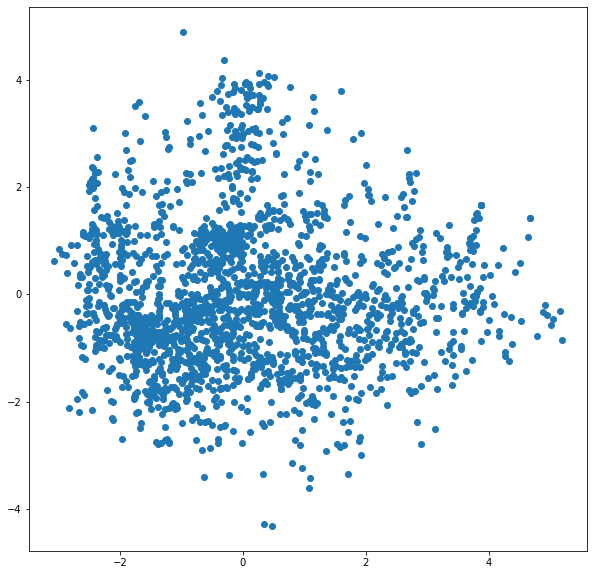

In [ ]:
plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0], X_pca[:, 1])
plt.xlabel('')
plt.ylabel('')    
plt.show()